✅ Toate cele 7 grafice au fost salvate corect, fără polilinii.


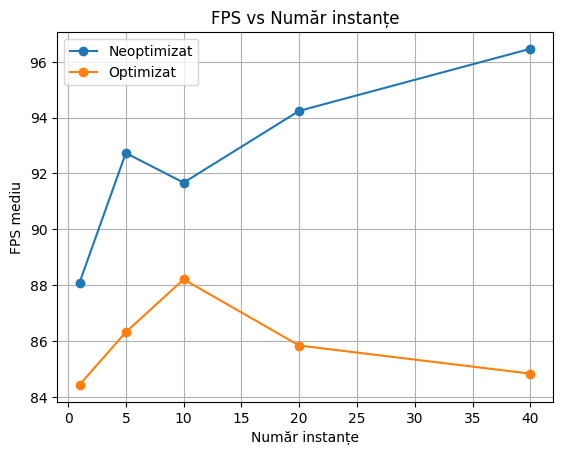

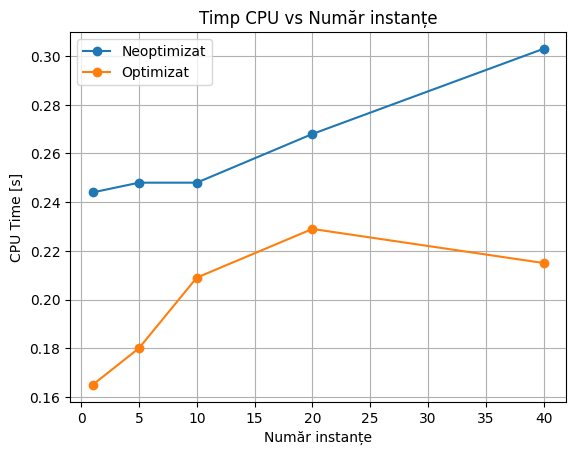

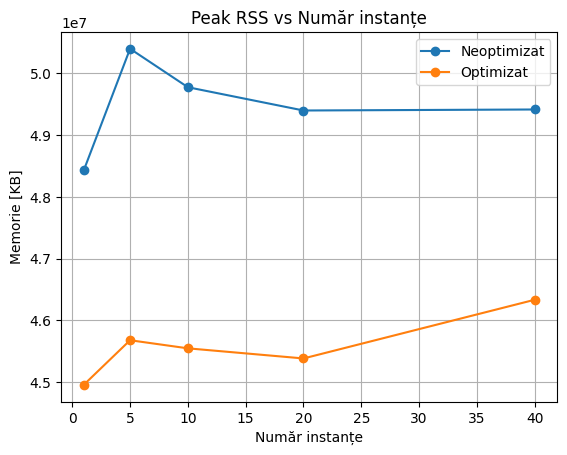

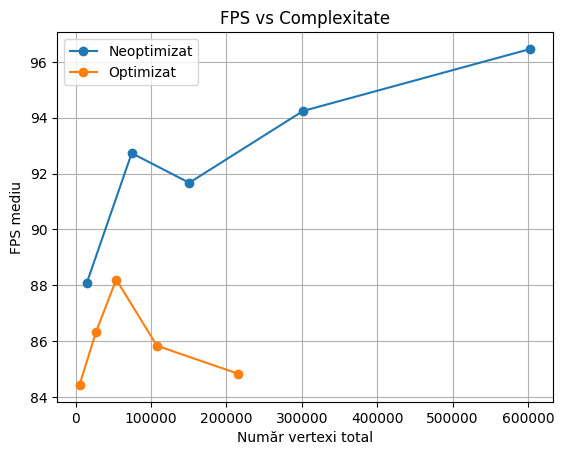

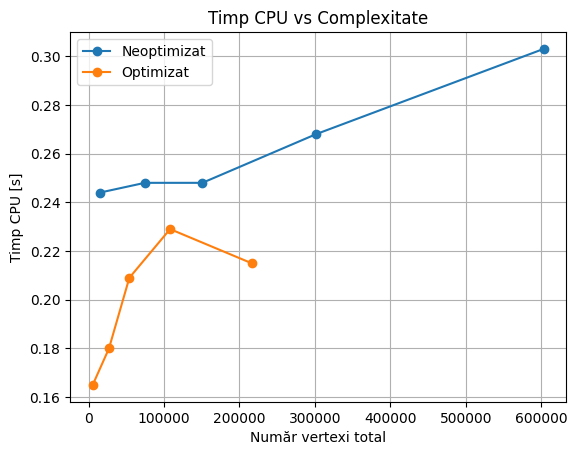

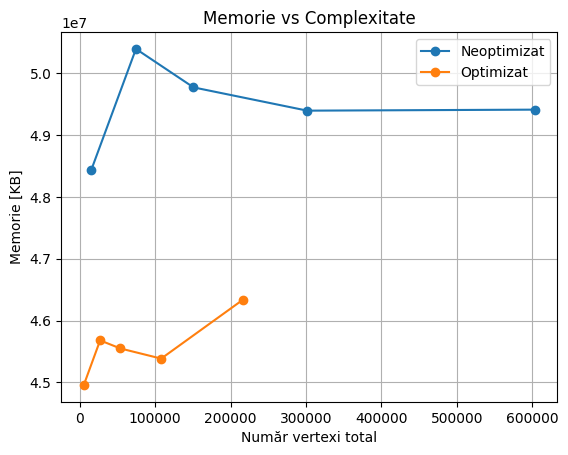

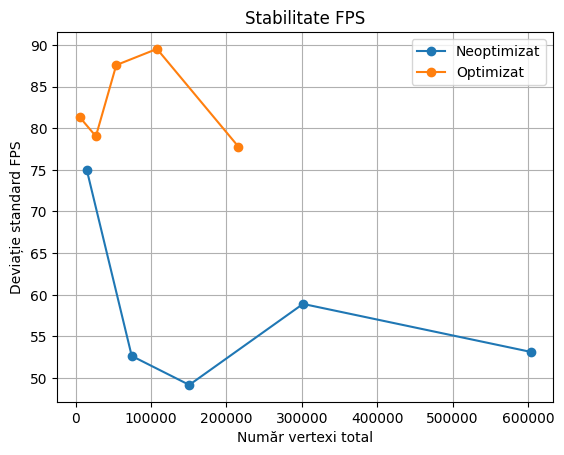

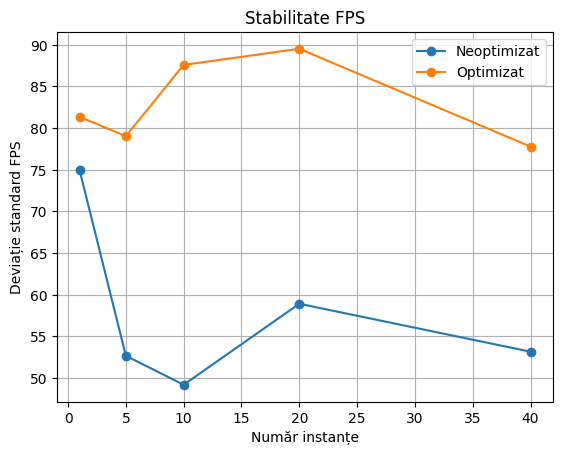

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def read_metrics_from_file(filename):
    try:
        df = pd.read_csv(filename, dtype=str, on_bad_lines='skip')
        df_numeric = df[df['frame'].apply(lambda x: x.isdigit())].astype({'dt_ms': float})
        avg_dt = df_numeric['dt_ms'].mean()
        std_dt = df_numeric['dt_ms'].std()
        fps = 1000.0 / avg_dt if avg_dt > 0 else 0

        with open(filename, "r", encoding="utf-8") as f:
            lines = f.readlines()[-4:]

        cpu = float(lines[1].split(',')[1]) if 'cpu_time' in lines[1] else None
        rss = float(lines[2].split(',')[1]) if 'peak_rss_kb' in lines[2] else None
        verts = int(lines[3].split(',')[1]) if 'vertex_count' in lines[3] else None
        count = int(filename.split('_')[1].split('.')[0])

        return {
            'count': count,
            'avg_fps': fps,
            'std_fps': 1000.0 * std_dt / (avg_dt ** 2) if avg_dt > 0 else 0,
            'cpu_time': cpu,
            'peak_rss_kb': rss,
            'vertex_count': verts
        }
    except Exception as e:
        print(f"❌ Eroare în {filename}: {e}")
        return None

# Adună fișierele
raw_files = sorted([f for f in os.listdir('.') if f.startswith('raw_') and f.endswith('.csv')])
opt_files = sorted([f for f in os.listdir('.') if f.startswith('opt_') and f.endswith('.csv')])

# Construiește DataFrame-urile
raw_data = [x for x in map(read_metrics_from_file, raw_files) if x is not None]
opt_data = [x for x in map(read_metrics_from_file, opt_files) if x is not None]
raw_df = pd.DataFrame(raw_data)
opt_df = pd.DataFrame(opt_data)

# Sortează după count
raw_df = raw_df.sort_values(by='count')
opt_df = opt_df.sort_values(by='count')

def plot_line(x1, y1, x2, y2, xlabel, ylabel, title, filename):
    plt.figure()
    plt.plot(x1, y1, 'o-', label='Neoptimizat')
    plt.plot(x2, y2, 'o-', label='Optimizat')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)

# === Generează graficele ===
plot_line(raw_df['count'], raw_df['avg_fps'], opt_df['count'], opt_df['avg_fps'],
          'Număr instanțe', 'FPS mediu', 'FPS vs Număr instanțe', 'fps_vs_count.png')

plot_line(raw_df['count'], raw_df['cpu_time'], opt_df['count'], opt_df['cpu_time'],
          'Număr instanțe', 'CPU Time [s]', 'Timp CPU vs Număr instanțe', 'cpu_vs_count.png')

plot_line(raw_df['count'], raw_df['peak_rss_kb'], opt_df['count'], opt_df['peak_rss_kb'],
          'Număr instanțe', 'Memorie [KB]', 'Peak RSS vs Număr instanțe', 'mem_vs_count.png')

plot_line(raw_df['vertex_count'], raw_df['avg_fps'], opt_df['vertex_count'], opt_df['avg_fps'],
          'Număr vertexi total', 'FPS mediu', 'FPS vs Complexitate', 'fps_vs_vertex_count.png')

plot_line(raw_df['vertex_count'], raw_df['cpu_time'], opt_df['vertex_count'], opt_df['cpu_time'],
          'Număr vertexi total', 'Timp CPU [s]', 'Timp CPU vs Complexitate', 'cpu_vs_vertex_count.png')

plot_line(raw_df['vertex_count'], raw_df['peak_rss_kb'], opt_df['vertex_count'], opt_df['peak_rss_kb'],
          'Număr vertexi total', 'Memorie [KB]', 'Memorie vs Complexitate', 'mem_vs_vertex_count.png')

plot_line(raw_df['vertex_count'], raw_df['std_fps'], opt_df['vertex_count'], opt_df['std_fps'],
          'Număr vertexi total', 'Deviație standard FPS', 'Stabilitate FPS', 'std_fps_vs_vertex_count.png')
plot_line(raw_df['count'], raw_df['std_fps'], opt_df['count'], opt_df['std_fps'],
          'Număr instanțe', 'Deviație standard FPS', 'Stabilitate FPS', 'std_fps_vs_count.png')

print("✅ Toate cele 7 grafice au fost salvate corect, fără polilinii.")

Optimizare

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Citește fișierul CSV (fără antet)
df = pd.read_csv("optimize_times.csv", header=None)
df.columns = ['filename', 'verts_before', 'opt_time_sec', 'verts_after']

# Sortează după numărul inițial de vertexi
df = df.sort_values(by='verts_before')

# Calculează reducerea procentuală
df['reduction_pct'] = 100 * (df['verts_before'] - df['verts_after']) / df['verts_before']

# ✅ Calculează media reducerii
mean_reduction = df['reduction_pct'].mean()
print(f"📉 Reducerea medie a vertexilor: {mean_reduction:.2f}%")

# === GRAFIC 1: Timp optimizare vs vertexi inițiali ===
plt.figure(figsize=(10, 4))  # Mai lat
plt.plot(df['verts_before'], df['opt_time_sec'], 'o-')
plt.xlabel('Număr vertexi inițiali')
plt.ylabel('Timp optimizare [s]')
plt.title('Timp optimizare vs Complexitate')
plt.ticklabel_format(style='plain', axis='x')  # 🔧 elimină 1e8
plt.grid(True)
plt.tight_layout()
plt.savefig("opt_time_vs_complexity.png")
# # === GRAFIC 1: Timp optimizare vs vertexi inițiali ===
# plt.figure(figsize=(10, 4))  # Mai lat
# plt.plot(df['verts_before'], df['opt_time_sec'], 'o-')
# plt.xlabel('Număr vertexi inițiali')
# plt.ylabel('Timp optimizare [s]')
# plt.title('Timp optimizare vs Complexitate')
# plt.grid(True)
# plt.tight_layout()
# plt.savefig("opt_time_vs_complexity.png")

# === GRAFIC 2: Reducere procentuală vertexi ===
plt.figure(figsize=(12, 0.3 * len(df)))  # Mai înalt pentru multe bare
plt.barh(df['filename'], df['reduction_pct'])
plt.xlabel('Reducere % vertexi')
plt.title('Reducere proporțională după optimizare')
plt.tight_layout()
plt.savefig("reduction_pct.png")

# === GRAFIC 3: Vertexi inițiali vs finali ===
plt.figure(figsize=(10, 4))
plt.plot(df['verts_before'], df['verts_after'], 'o-')
plt.xlabel('Vertexi înainte')
plt.ylabel('Vertexi după')
plt.title('Complexitate: Înainte vs După optimizare')
plt.grid(True)
plt.tight_layout()
plt.savefig("verts_before_vs_after.png")

print("✅ Grafice salvate: opt_time_vs_complexity.png, reduction_pct.png, verts_before_vs_after.png")

📉 Reducerea medie a vertexilor: -762.76%


KeyError: 'size_mb_before'

<Figure size 1000x400 with 0 Axes>

Generare

✅ Grafice salvate: gen_time_vs_iter.png, txt_write_vs_iter.png, obj_gen_vs_iter.png, total_time_vs_iter.png, string_length_vs_iter.png


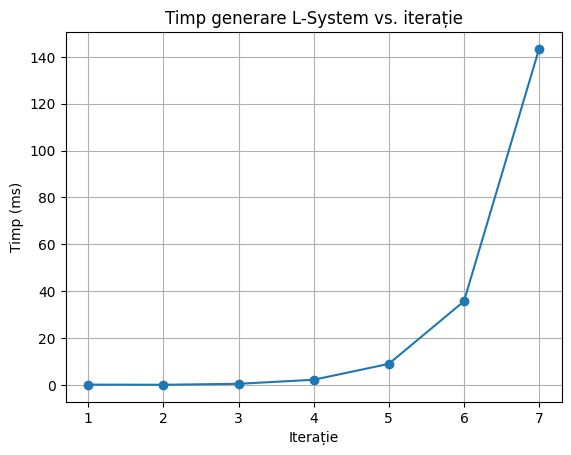

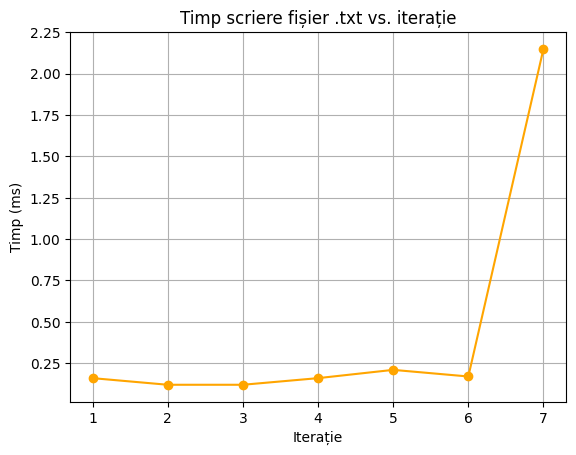

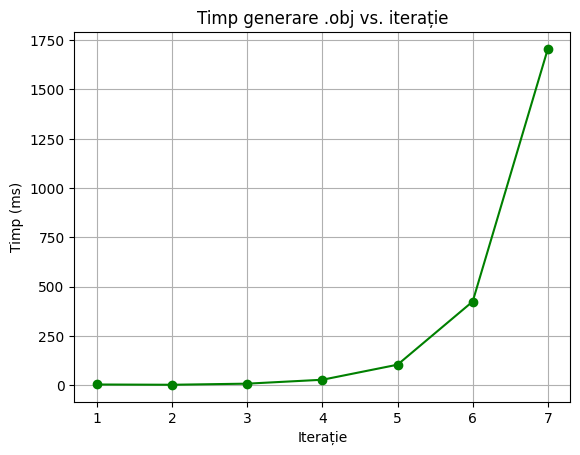

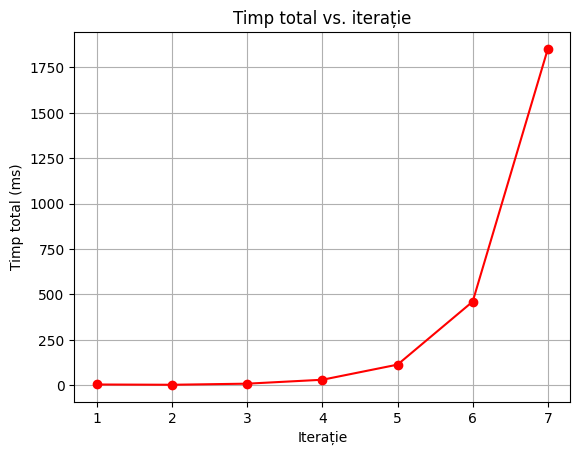

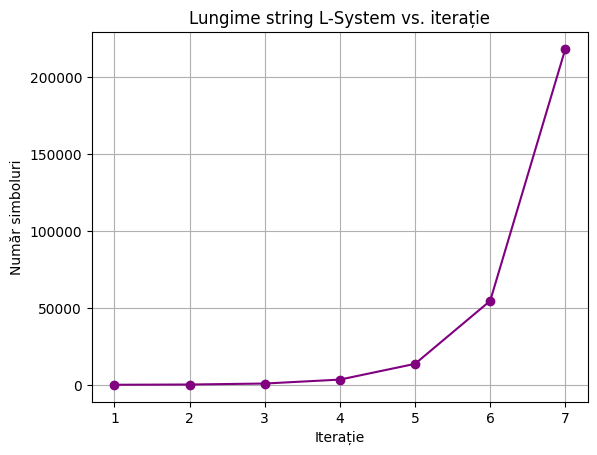

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# === Citire CSV ===
df = pd.read_csv("benchmark_full_generation.csv")

# Asigurare tipuri numerice
df['iteration'] = pd.to_numeric(df['iteration'], errors='coerce')
df['generate_ms'] = pd.to_numeric(df['generate_ms'], errors='coerce')
df['txt_write_ms'] = pd.to_numeric(df['txt_write_ms'], errors='coerce')
df['obj_gen_ms'] = pd.to_numeric(df['obj_gen_ms'], errors='coerce')
df['total_ms'] = pd.to_numeric(df['total_ms'], errors='coerce')
df['string_length'] = pd.to_numeric(df['string_length'], errors='coerce')

# Eliminare rânduri invalide
df = df.dropna()

# === 1. Timp generare L-System ===
plt.figure()
plt.plot(df['iteration'], df['generate_ms'], 'o-', label='Timp generare regulă')
plt.xlabel('Iterație')
plt.ylabel('Timp (ms)')
plt.title('Timp generare L-System vs. iterație')
plt.grid(True)
plt.savefig("gen_time_vs_iter.png")

# === 2. Timp scriere fișier TXT ===
plt.figure()
plt.plot(df['iteration'], df['txt_write_ms'], 'o-', label='Timp scriere .txt', color='orange')
plt.xlabel('Iterație')
plt.ylabel('Timp (ms)')
plt.title('Timp scriere fișier .txt vs. iterație')
plt.grid(True)
plt.savefig("txt_write_vs_iter.png")

# === 3. Timp generare .obj ===
plt.figure()
plt.plot(df['iteration'], df['obj_gen_ms'], 'o-', label='Timp generare .obj', color='green')
plt.xlabel('Iterație')
plt.ylabel('Timp (ms)')
plt.title('Timp generare .obj vs. iterație')
plt.grid(True)
plt.savefig("obj_gen_vs_iter.png")

# === 4. Timp total ===
plt.figure()
plt.plot(df['iteration'], df['total_ms'], 'o-', label='Timp total', color='red')
plt.xlabel('Iterație')
plt.ylabel('Timp total (ms)')
plt.title('Timp total vs. iterație')
plt.grid(True)
plt.savefig("total_time_vs_iter.png")

# === 5. Lungime string generat ===
plt.figure()
plt.plot(df['iteration'], df['string_length'], 'o-', label='Lungime șir', color='purple')
plt.xlabel('Iterație')
plt.ylabel('Număr simboluri')
plt.title('Lungime string L-System vs. iterație')
plt.grid(True)
plt.savefig("string_length_vs_iter.png")

print("✅ Grafice salvate: gen_time_vs_iter.png, txt_write_vs_iter.png, obj_gen_vs_iter.png, total_time_vs_iter.png, string_length_vs_iter.png")

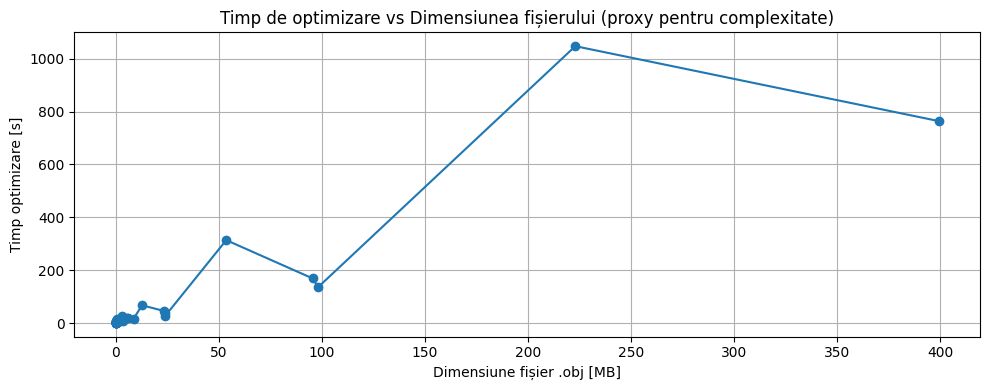

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Citește CSV-ul fără antet
df = pd.read_csv("optimize_times.csv", header=None)
df.columns = ['filename', 'size_bytes_before', 'opt_time_sec', 'size_bytes_after']

# Sortează după mărimea inițială
df = df.sort_values(by='size_bytes_before')

# Convertim octeții în megabytes
df['size_mb_before'] = df['size_bytes_before'] / (1024 * 1024)

# === GRAFIC VERIDIC: Timp vs Dimensiune (.obj) ===
plt.figure(figsize=(10, 4))
plt.plot(df['size_mb_before'], df['opt_time_sec'], 'o-')
plt.xlabel('Dimensiune fișier .obj [MB]')
plt.ylabel('Timp optimizare [s]')
plt.title('Timp de optimizare vs Dimensiunea fișierului (proxy pentru complexitate)')
plt.grid(True)
plt.tight_layout()
plt.savefig("opt_time_vs_complexity.png")  # Salvează cu același nume